In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
from os import listdir
from os.path import isfile, join
import math
import numpy as np
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt 
from scipy.ndimage import rotate
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges
import scipy.sparse as sp
from scipy.linalg import block_diag
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import tarfile
import torch.nn.functional as F
import copy
import time
from torch_scatter import scatter_mean, scatter_max, scatter_add
from torch_geometric.utils import remove_self_loops, add_self_loops
from torch_geometric.datasets import Planetoid
import networkx as nx
import scipy.io as sio
import torch_scatter
import inspect
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import copy
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from matplotlib.ticker import MaxNLocator

In [7]:
# read 10 gml files
mypath = "../graphml/day/"
file_list = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and  f.endswith('bz2'))]
file_list = sorted(file_list)

In [8]:
def select_files(file_list, filename, num_files, hop):
    if filename not in file_list:
        raise ValueError("Target filename not found in the list")
    
    target_index = file_list.index(filename)
    
    selected_indices = [target_index]
    current_index = target_index
    while len(selected_indices) < num_files:
        current_index -= hop
        if current_index < 0:
            break
        selected_indices.append(current_index)
    
    selected_indices = selected_indices[::-1]  # Reverse the order
    
    selected_files = [file_list[idx] for idx in selected_indices]
    return selected_files

In [40]:
select_day = "2012-03-05"

In [41]:
files = select_files(file_list, select_day+'.graphml.bz2',30, 1)

In [43]:
# union set of all nodes
g = []
nodes = sorted(list(nx.read_graphml(mypath + files[-1]).nodes))
for i in range(30):
    gi = nx.read_graphml(mypath + files[i])
    g.append(gi) 

In [44]:
# for week month year
def find_edges_in_nodes(node_list, graph_list):
    result_edges = []
    # traverse the interval
    for graph in graph_list:
        # traverse the edges
        for edge in graph.edges():
            source, target = edge
            if source in node_list and target in node_list:
                result_edges.append(edge)
    
    return result_edges

In [ ]:
# generate different adj matrices for dfifferent snapshots with their edges 

adj = []
for i in range(30):
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(find_edges_in_nodes(nodes, [g[i]]))
    if (graph.number_of_edges() < 20):
        continue
    A = nx.adjacency_matrix(graph).astype(np.uint8)
    adj.append(A)

In [46]:
adj_tensor = []

for i in range(len(adj)):
    adj_tensor.append(torch.tensor(adj[i].toarray()).to(torch.float32))

In [47]:
adj

[<8701x8701 sparse array of type '<class 'numpy.uint8'>'
 	with 2180 stored elements in Compressed Sparse Row format>,
 <8701x8701 sparse array of type '<class 'numpy.uint8'>'
 	with 2146 stored elements in Compressed Sparse Row format>,
 <8701x8701 sparse array of type '<class 'numpy.uint8'>'
 	with 2250 stored elements in Compressed Sparse Row format>,
 <8701x8701 sparse array of type '<class 'numpy.uint8'>'
 	with 2106 stored elements in Compressed Sparse Row format>,
 <8701x8701 sparse array of type '<class 'numpy.uint8'>'
 	with 2416 stored elements in Compressed Sparse Row format>,
 <8701x8701 sparse array of type '<class 'numpy.uint8'>'
 	with 2216 stored elements in Compressed Sparse Row format>,
 <8701x8701 sparse array of type '<class 'numpy.uint8'>'
 	with 2328 stored elements in Compressed Sparse Row format>,
 <8701x8701 sparse array of type '<class 'numpy.uint8'>'
 	with 2374 stored elements in Compressed Sparse Row format>,
 <8701x8701 sparse array of type '<class 'numpy.

In [5]:
with open('/Users/eva/Downloads/FS23/MasterProject/code/adj_day_50_2011_10_01.pickle', 'rb') as handle:
    adj = pickle.load(handle,encoding='iso-8859-1')

In [25]:
file_path = '/Users/eva/Downloads/FS23/MasterProject/code/adj_day_30_2012_04_24.pickle'

# Writing (pickling) the list to a file
with open(file_path, 'wb') as file:
    pickle.dump(adj, file)

In [48]:
seed = 3
np.random.seed(seed)

In [49]:
def uniform(size, tensor):
    stdv = 1.0 / math.sqrt(size)
    if tensor is not None:
        tensor.data.uniform_(-stdv, stdv)


def glorot(tensor):
    stdv = math.sqrt(6.0 / (tensor.size(0) + tensor.size(1)))
    if tensor is not None:
        tensor.data.uniform_(-stdv, stdv)


def zeros(tensor):
    if tensor is not None:
        tensor.data.fill_(0)


def ones(tensor):
    if tensor is not None:
        tensor.data.fill_(1)


def reset(nn):
    def _reset(item):
        if hasattr(item, 'reset_parameters'):
            item.reset_parameters()

    if nn is not None:
        if hasattr(nn, 'children') and len(list(nn.children())) > 0:
            for item in nn.children():
                _reset(item)
        else:
            _reset(nn)


def scatter_(name, src, index, dim_size=None):

    assert name in ['add', 'mean', 'max']

    op = getattr(torch_scatter, 'scatter_{}'.format(name))
    fill_value = -1e38 if name is 'max' else 0

    out = op(src, index, 0, None, dim_size, fill_value)
    if isinstance(out, tuple):
        out = out[0]

    if name is 'max':
        out[out == fill_value] = 0

    return out

<>:56: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:62: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:56: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:62: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/7r/ldjcp71d7rl9t4lb3_r0llxc0000gn/T/ipykernel_94583/3553926969.py:56: SyntaxWarning: "is" with a literal. Did you mean "=="?
  fill_value = -1e38 if name is 'max' else 0
/var/folders/7r/ldjcp71d7rl9t4lb3_r0llxc0000gn/T/ipykernel_94583/3553926969.py:62: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if name is 'max':


In [28]:
class MessagePassing(torch.nn.Module):

    def __init__(self, aggr='add'):
        super(MessagePassing, self).__init__()

        self.message_args = inspect.getargspec(self.message)[0][1:]
        self.update_args = inspect.getargspec(self.update)[0][2:]

    def propagate(self, aggr, edge_index, **kwargs):

        assert aggr in ['add', 'mean', 'max']
        kwargs['edge_index'] = edge_index

        size = None
        message_args = []
        for arg in self.message_args:
            if arg[-2:] == '_i':
                tmp = kwargs[arg[:-2]]
                size = tmp.size(0)
                message_args.append(tmp[edge_index[0]])
            elif arg[-2:] == '_j':
                tmp = kwargs[arg[:-2]]
                size = tmp.size(0)
                message_args.append(tmp[edge_index[1]])
            else:
                message_args.append(kwargs[arg])

        update_args = [kwargs[arg] for arg in self.update_args]

        out = self.message(*message_args)
        out = scatter_(aggr, out, edge_index[0], dim_size=size)
        out = self.update(out, *update_args)

        return out

    def message(self, x_j):  # pragma: no cover

        return x_j

    def update(self, aggr_out):  # pragma: no cover

        return aggr_out


In [29]:
def tuple_to_array(lot):
    out = np.array(list(lot[0]))
    for i in range(1, len(lot)):
        out = np.vstack((out, np.array(list(lot[i]))))
    
    return out

In [30]:
def mask_edges_prd(adjs_list):
    adj_train_l, train_edges_l, val_edges_l = [], [], []
    val_edges_false_l, test_edges_l, test_edges_false_l = [], [], []
    edges_list = []
    for i in range(0, len(adjs_list)):
        # Function to build test set with 10% positive links
        # NOTE: Splits are randomized and results might slightly deviate from reported numbers in the paper.
        
        adj = adjs_list[i]
        # Remove diagonal elements
        adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis], [0]), shape=adj.shape)
        adj.eliminate_zeros()
        # Check that diag is zero:
        assert np.diag(adj.todense()).sum() == 0
        
        #Convert the upper triangular part of the adjacency matrix to a sparse matrix and extract the edges.
        adj_triu = sp.triu(adj)
        edges = sparse_to_tuple(adj_triu)[0]   # a half of all edges
        edges_all = sparse_to_tuple(adj)[0]
        num_test = int(np.floor(edges.shape[0] / 10))
        num_val = int(np.floor(edges.shape[0] / 20))
        
        all_edge_idx = list(range(edges.shape[0]))  #convert the range object to a list before shuffling it
        np.random.shuffle(all_edge_idx)
        val_edge_idx = all_edge_idx[:num_val]
        test_edge_idx = all_edge_idx[num_val:(num_val + num_test)]
        test_edges = edges[test_edge_idx]
        val_edges = edges[val_edge_idx]
        train_edges = np.delete(edges, np.hstack([test_edge_idx, val_edge_idx]), axis=0)
        
        edges_list.append(edges)
        
        def ismember(a, b, tol=5):
            rows_close = np.all(np.round(a - b[:, None], tol) == 0, axis=-1)
            return np.any(rows_close)

        test_edges_false = []
        while len(test_edges_false) < len(test_edges):
            idx_i = np.random.randint(0, adj.shape[0])
            idx_j = np.random.randint(0, adj.shape[0])
            if idx_i == idx_j or ismember([idx_i, idx_j], edges_all):
                continue
            if ismember([idx_j, idx_i],np.array(test_edges_false)) or ismember([idx_i, idx_j],np.array(test_edges_false)):
                continue
            test_edges_false.append([idx_i, idx_j])

        val_edges_false = []
        while len(val_edges_false) < len(val_edges):
            idx_i = np.random.randint(0, adj.shape[0])
            idx_j = np.random.randint(0, adj.shape[0])
            if idx_i == idx_j:
                continue
            if ismember([idx_i, idx_j], train_edges) or ismember([idx_j, idx_i], train_edges):
                continue
            if ismember([idx_i, idx_j], val_edges) or ismember([idx_j, idx_i], val_edges):
                continue
            if ismember([idx_j, idx_i], np.array(val_edges_false)) or ismember([idx_i, idx_j], np.array(val_edges_false)):
                continue
            val_edges_false.append([idx_i, idx_j])

        assert ~ismember(test_edges_false, edges_all)
        assert ~ismember(val_edges_false, edges_all)
        assert ~ismember(val_edges, train_edges)
        assert ~ismember(test_edges, train_edges)
        assert ~ismember(val_edges, test_edges)

        data = np.ones(train_edges.shape[0])

        # Re-build adj matrix
        adj_train = sp.csr_matrix((data, (train_edges[:, 0], train_edges[:, 1])), shape=adj.shape)
        adj_train = adj_train + adj_train.T

        adj_train_l.append(adj_train)
        train_edges_l.append(train_edges)
        val_edges_l.append(val_edges)
        val_edges_false_l.append(val_edges_false)
        test_edges_l.append(test_edges)
        test_edges_false_l.append(test_edges_false)

    # NOTE: these edge lists only contain single direction of edge!
    return adj_train_l, train_edges_l, val_edges_l, val_edges_false_l, test_edges_l, test_edges_false_l


In [50]:
adj_time_list = adj
adj_orig_dense_list = adj_tensor

In [51]:
# train_edges_ln, pos_edges_ln, false_edges_ln = mask_edges_prd(adj_time_list)
outs = mask_edges_prd(adj_time_list)

adj_train_l = outs[0]
train_edges_l = outs[1]
val_edges_l = outs[2]
val_edges_false_l = outs[3]
test_edges_l = outs[4]
test_edges_false_l = outs[5]


# creating edge list

edge_idx_list = []

for i in range(len(train_edges_l)):
    edge_idx_list.append(torch.tensor(np.transpose(train_edges_l[i]), dtype=torch.long))

In [33]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels, act=F.relu, improved=True, bias=False):
        super(GCNConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.improved = improved
        self.act = act

        self.weight = Parameter(torch.Tensor(in_channels, out_channels))

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        zeros(self.bias)

    def forward(self, x, edge_index, edge_weight=None):
        if edge_weight is None:
            edge_weight = torch.ones(
                (edge_index.size(1), ), dtype=x.dtype, device=x.device)
        edge_weight = edge_weight.view(-1)
        assert edge_weight.size(0) == edge_index.size(1)

        edge_index = add_self_loops(edge_index, num_nodes=x.size(0))
        loop_weight = torch.full(
            (x.size(0), ),
            1 if not self.improved else 2,
            dtype=x.dtype,
            device=x.device)
        edge_weight = torch.cat([edge_weight, loop_weight], dim=0)

        row, col = edge_index
        deg = scatter_add(edge_weight, row, dim=0, dim_size=x.size(0))
        deg_inv = deg.pow(-0.5)
        deg_inv[deg_inv == float('inf')] = 0

        norm = deg_inv[row] * edge_weight * deg_inv[col]

        x = torch.matmul(x, self.weight)
        out = self.propagate('add', edge_index, x=x, norm=norm)
        return self.act(out)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        if self.bias is not None:
            aggr_out = aggr_out + self.bias
        return aggr_out

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)


class SAGEConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels, pool='mean', act=F.relu, normalize=False, bias=False):
        super(SAGEConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.weight = Parameter(torch.Tensor(self.in_channels, out_channels))
        self.act = act
        self.pool = pool
        
        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        size = self.weight.size(0)
        uniform(size, self.weight)
        uniform(size, self.bias)

    def forward(self, x, edge_index):
        edge_index, _ = remove_self_loops(edge_index)
        edge_index = add_self_loops(edge_index, num_nodes=x.size(0))
        
        x = x.unsqueeze(-1) if x.dim() == 1 else x
        row, col = edge_index
        
        if self.pool == 'mean':
            out = torch.matmul(x, self.weight)
            if self.bias is not None:
                out = out + self.bias
            out = self.act(out)
            out = scatter_mean(out[col], row, dim=0, dim_size=out.size(0))
            
        elif self.pool == 'max':
            out = torch.matmul(x, self.weight)
            if self.bias is not None:
                out = out + self.bias
            out = self.act(out)
            out, _ = scatter_max(out[col], row, dim=0, dim_size=out.size(0))
            
        elif self.pool == 'add':
            x = torch.matmul(x, self.weight)
            if self.bias is not None:
                out = out + self.bias
            out = self.act(out)
            out = scatter_add(x[col], row, dim=0, dim_size=x.size(0))
        else:
            print('pooling not defined!')
                
        if self.normalize:
            out = F.normalize(out, p=2, dim=-1)
        
        return out
    
    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels, self.out_channels)

class GINConv(torch.nn.Module):
    def __init__(self, nn, eps=0, train_eps=False):
        super(GINConv, self).__init__()
        self.nn = nn
        self.initial_eps = eps
        if train_eps:
            self.eps = torch.nn.Parameter(torch.Tensor([eps]))
        else:
            self.register_buffer('eps', torch.Tensor([eps]))
        self.reset_parameters()

    def reset_parameters(self):
        reset(self.nn)
        self.eps.data.fill_(self.initial_eps)

    def forward(self, x, edge_index):
        x = x.unsqueeze(-1) if x.dim() == 1 else x
        edge_index, _ = remove_self_loops(edge_index)
        row, col = edge_index

        out = scatter_add(x[col], row, dim=0, dim_size=x.size(0))
        out = (1 + self.eps) * x + out
        out = self.nn(out)
        return out

    def __repr__(self):
        return '{}(nn={})'.format(self.__class__.__name__, self.nn)

class graph_gru_sage(nn.Module):
    def __init__(self, input_size, hidden_size, n_layer, bias=True):
        super(graph_gru_sage, self).__init__()

        self.hidden_size = hidden_size
        self.n_layer = n_layer
        
        # gru weights
        self.weight_xz = []
        self.weight_hz = []
        self.weight_xr = []
        self.weight_hr = []
        self.weight_xh = []
        self.weight_hh = []
        
        for i in range(self.n_layer):
            if i==0:
                self.weight_xz.append(SAGEConv(input_size, hidden_size, act=lambda x:x, bias=bias))
                self.weight_hz.append(SAGEConv(hidden_size, hidden_size, act=lambda x:x, bias=bias))
                self.weight_xr.append(SAGEConv(input_size, hidden_size, act=lambda x:x, bias=bias))
                self.weight_hr.append(SAGEConv(hidden_size, hidden_size, act=lambda x:x, bias=bias))
                self.weight_xh.append(SAGEConv(input_size, hidden_size, act=lambda x:x, bias=bias))
                self.weight_hh.append(SAGEConv(hidden_size, hidden_size, act=lambda x:x, bias=bias))
            else:
                self.weight_xz.append(SAGEConv(hidden_size, hidden_size, act=lambda x:x, bias=bias))
                self.weight_hz.append(SAGEConv(hidden_size, hidden_size, act=lambda x:x, bias=bias))
                self.weight_xr.append(SAGEConv(hidden_size, hidden_size, act=lambda x:x, bias=bias))
                self.weight_hr.append(SAGEConv(hidden_size, hidden_size, act=lambda x:x, bias=bias))
                self.weight_xh.append(SAGEConv(hidden_size, hidden_size, act=lambda x:x, bias=bias))
                self.weight_hh.append(SAGEConv(hidden_size, hidden_size, act=lambda x:x, bias=bias))
    
    def forward(self, inp, edgidx, h):
        h_out = torch.zeros(h.size())
        for i in range(self.n_layer):
            if i==0:
                z_g = torch.sigmoid(self.weight_xz[i](inp, edgidx) + self.weight_hz[i](h[i], edgidx))
                r_g = torch.sigmoid(self.weight_xr[i](inp, edgidx) + self.weight_hr[i](h[i], edgidx))
                h_tilde_g = torch.tanh(self.weight_xh[i](inp, edgidx) + self.weight_hh[i](r_g * h[i], edgidx))
                h_out[i] = z_g * h[i] + (1 - z_g) * h_tilde_g
        #         out = self.decoder(h_t.view(1,-1))
            else:
                z_g = torch.sigmoid(self.weight_xz[i](h_out[i-1], edgidx) + self.weight_hz[i](h[i], edgidx))
                r_g = torch.sigmoid(self.weight_xr[i](h_out[i-1], edgidx) + self.weight_hr[i](h[i], edgidx))
                h_tilde_g = torch.tanh(self.weight_xh[i](h_out[i-1], edgidx) + self.weight_hh[i](r_g * h[i], edgidx))
                h_out[i] = z_g * h[i] + (1 - z_g) * h_tilde_g
        #         out = self.decoder(h_t.view(1,-1))
        
        out = h_out
        return out, h_out


class graph_gru_gcn(nn.Module):
    def __init__(self, input_size, hidden_size, n_layer, bias=True):
        super(graph_gru_gcn, self).__init__()

        self.hidden_size = hidden_size
        self.n_layer = n_layer
        
        # gru weights
        self.weight_xz = []
        self.weight_hz = []
        self.weight_xr = []  
        self.weight_hr = []
        self.weight_xh = []
        self.weight_hh = []
        
        for i in range(self.n_layer):
            if i==0:
                self.weight_xz.append(GCNConv(input_size, hidden_size, act=lambda x:x, bias=bias))
                self.weight_hz.append(GCNConv(hidden_size, hidden_size, act=lambda x:x, bias=bias))
                self.weight_xr.append(GCNConv(input_size, hidden_size, act=lambda x:x, bias=bias))
                self.weight_hr.append(GCNConv(hidden_size, hidden_size, act=lambda x:x, bias=bias))
                self.weight_xh.append(GCNConv(input_size, hidden_size, act=lambda x:x, bias=bias))
                self.weight_hh.append(GCNConv(hidden_size, hidden_size, act=lambda x:x, bias=bias))
            else:
                self.weight_xz.append(GCNConv(hidden_size, hidden_size, act=lambda x:x, bias=bias))
                self.weight_hz.append(GCNConv(hidden_size, hidden_size, act=lambda x:x, bias=bias))
                self.weight_xr.append(GCNConv(hidden_size, hidden_size, act=lambda x:x, bias=bias))
                self.weight_hr.append(GCNConv(hidden_size, hidden_size, act=lambda x:x, bias=bias))
                self.weight_xh.append(GCNConv(hidden_size, hidden_size, act=lambda x:x, bias=bias))
                self.weight_hh.append(GCNConv(hidden_size, hidden_size, act=lambda x:x, bias=bias))
    
    def forward(self, inp, edgidx, h):
        h_out = torch.zeros(h.size())
        for i in range(self.n_layer):
            if i==0:
                z_g = torch.sigmoid(self.weight_xz[i](inp, edgidx) + self.weight_hz[i](h[i], edgidx))
                r_g = torch.sigmoid(self.weight_xr[i](inp, edgidx) + self.weight_hr[i](h[i], edgidx))
                h_tilde_g = torch.tanh(self.weight_xh[i](inp, edgidx) + self.weight_hh[i](r_g * h[i], edgidx))
                h_out[i] = z_g * h[i] + (1 - z_g) * h_tilde_g
        #         out = self.decoder(h_t.view(1,-1))
            else:
                z_g = torch.sigmoid(self.weight_xz[i](h_out[i-1], edgidx) + self.weight_hz[i](h[i], edgidx))
                r_g = torch.sigmoid(self.weight_xr[i](h_out[i-1], edgidx) + self.weight_hr[i](h[i], edgidx))
                h_tilde_g = torch.tanh(self.weight_xh[i](h_out[i-1], edgidx) + self.weight_hh[i](r_g * h[i], edgidx))
                h_out[i] = z_g * h[i] + (1 - z_g) * h_tilde_g
        #         out = self.decoder(h_t.view(1,-1))
        
        out = h_out
        return out, h_out


class InnerProductDecoder(nn.Module):
    def __init__(self, act=torch.sigmoid, dropout=0.):
        super(InnerProductDecoder, self).__init__()
        
        self.act = act
        self.dropout = dropout
    
    def forward(self, inp):
        inp = F.dropout(inp, self.dropout, training=self.training)
        x = torch.transpose(inp, dim0=0, dim1=1)
        x = torch.mm(inp, x)
        return self.act(x)

In [34]:
# evaluation function

def get_roc_scores(edges_pos, edges_neg, adj_orig_dense_list, embs):
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    auc_scores = []
    ap_scores = []
#     acc_scores = []
    
    for i in range(len(edges_pos)):
        # Predict on test set of edges
        emb = embs[i].detach().numpy()
        adj_rec = np.dot(emb, emb.T)
        adj_orig_t = adj_orig_dense_list[i]
        
        preds = []
        pos = []
        for e in edges_pos[i]:
            preds.append(sigmoid(adj_rec[e[0], e[1]]))
            pos.append(adj_orig_t[e[0], e[1]])
            
        preds_neg = []
        neg = []
        for e in edges_neg[i]:
            preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
            neg.append(adj_orig_t[e[0], e[1]])
        
        preds_all = np.hstack([preds, preds_neg])
        labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))]) 
        auc_scores.append(roc_auc_score(labels_all, preds_all))
        ap_scores.append(average_precision_score(labels_all, preds_all))

        
    return auc_scores, ap_scores

In [35]:
# VGRNN model

class VGRNN(nn.Module):
    def __init__(self, x_dim, h_dim, z_dim, n_layers, eps, conv='GCN', bias=False):
        super(VGRNN, self).__init__()
        
        self.x_dim = x_dim
        self.eps = eps
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.n_layers = n_layers
        
        if conv == 'GCN':
            self.phi_x = nn.Sequential(nn.Linear(x_dim, h_dim), nn.ReLU())
            self.phi_z = nn.Sequential(nn.Linear(z_dim, h_dim), nn.ReLU())
            
            self.enc = GCNConv(h_dim + h_dim, h_dim)            
            self.enc_mean = GCNConv(h_dim, z_dim, act=lambda x:x)
            self.enc_std = GCNConv(h_dim, z_dim, act=F.softplus)
            
            self.prior = nn.Sequential(nn.Linear(h_dim, h_dim), nn.ReLU())
            self.prior_mean = nn.Sequential(nn.Linear(h_dim, z_dim))
            self.prior_std = nn.Sequential(nn.Linear(h_dim, z_dim), nn.Softplus())
            
            self.rnn = graph_gru_gcn(h_dim + h_dim, h_dim, n_layers, bias)
            
        elif conv == 'SAGE':
            self.phi_x = nn.Sequential(nn.Linear(x_dim, h_dim), nn.ReLU())
            self.phi_z = nn.Sequential(nn.Linear(z_dim, h_dim), nn.ReLU())
            
            self.enc = SAGEConv(h_dim + h_dim, h_dim)
            self.enc_mean = SAGEConv(h_dim, z_dim, act=lambda x:x)
            self.enc_std = SAGEConv(h_dim, z_dim, act=F.softplus)
            
            self.prior = nn.Sequential(nn.Linear(h_dim, h_dim), nn.ReLU())
            self.prior_mean = nn.Sequential(nn.Linear(h_dim, z_dim))
            self.prior_std = nn.Sequential(nn.Linear(h_dim, z_dim), nn.Softplus())
            
            self.rnn = graph_gru_sage(h_dim + h_dim, h_dim, n_layers, bias)
            
        elif conv == 'GIN':
            self.phi_x = nn.Sequential(nn.Linear(x_dim, h_dim), nn.ReLU())
            self.phi_z = nn.Sequential(nn.Linear(z_dim, h_dim), nn.ReLU())
            
            self.enc = GINConv(nn.Sequential(nn.Linear(h_dim + h_dim, h_dim), nn.ReLU()))            
            self.enc_mean = GINConv(nn.Sequential(nn.Linear(h_dim, z_dim)))
            self.enc_std = GINConv(nn.Sequential(nn.Linear(h_dim, z_dim), nn.Softplus()))
            
            self.prior = nn.Sequential(nn.Linear(h_dim, h_dim), nn.ReLU())
            self.prior_mean = nn.Sequential(nn.Linear(h_dim, z_dim))
            self.prior_std = nn.Sequential(nn.Linear(h_dim, z_dim), nn.Softplus())
            
            self.rnn = graph_gru_gcn(h_dim + h_dim, h_dim, n_layers, bias)  
    
    def forward(self, x, edge_idx_list, adj_orig_dense_list, hidden_in=None):
        assert len(adj_orig_dense_list) == len(edge_idx_list)
        
        kld_loss = 0
        nll_loss = 0
        all_enc_mean, all_enc_std = [], []
        all_prior_mean, all_prior_std = [], []
        all_dec_t, all_z_t = [], []
        
        if hidden_in is None:
            h = Variable(torch.zeros(self.n_layers, x.size(1), self.h_dim))
        else:
            h = Variable(hidden_in)
        
        for t in range(x.size(0)):
            phi_x_t = self.phi_x(x[t])
            
            #encoder
            enc_t = self.enc(torch.cat([phi_x_t, h[-1]], 1), edge_idx_list[t])
            enc_mean_t = self.enc_mean(enc_t, edge_idx_list[t])
            enc_std_t = self.enc_std(enc_t, edge_idx_list[t])
            
            #prior
            prior_t = self.prior(h[-1])
            prior_mean_t = self.prior_mean(prior_t)
            prior_std_t = self.prior_std(prior_t)
            
            #sampling and reparameterization
            z_t = self._reparameterized_sample(enc_mean_t, enc_std_t)
            phi_z_t = self.phi_z(z_t)
            
            #decoder
            dec_t = self.dec(z_t)
            
            #recurrence
            _, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1), edge_idx_list[t], h)
            
            nnodes = adj_orig_dense_list[t].size()[0]
            enc_mean_t_sl = enc_mean_t[0:nnodes, :]
            enc_std_t_sl = enc_std_t[0:nnodes, :]
            prior_mean_t_sl = prior_mean_t[0:nnodes, :]
            prior_std_t_sl = prior_std_t[0:nnodes, :]
            dec_t_sl = dec_t[0:nnodes, 0:nnodes]
            
            #computing losses
#             kld_loss += self._kld_gauss_zu(enc_mean_t, enc_std_t)
            kld_loss += self._kld_gauss(enc_mean_t_sl, enc_std_t_sl, prior_mean_t_sl, prior_std_t_sl)
            nll_loss += self._nll_bernoulli(dec_t_sl, adj_orig_dense_list[t])
            
            all_enc_std.append(enc_std_t_sl)
            all_enc_mean.append(enc_mean_t_sl)
            all_prior_mean.append(prior_mean_t_sl)
            all_prior_std.append(prior_std_t_sl)
            all_dec_t.append(dec_t_sl)
            all_z_t.append(z_t)
        
        return kld_loss, nll_loss, all_enc_mean, all_prior_mean, h
    
    def dec(self, z):
        outputs = InnerProductDecoder(act=lambda x:x)(z)
        return outputs
    
    def reset_parameters(self, stdv=1e-1):
        for weight in self.parameters():
            weight.data.normal_(0, stdv)
     
    def _init_weights(self, stdv):
        pass
    
    def _reparameterized_sample(self, mean, std):
        eps1 = torch.FloatTensor(std.size()).normal_()
        eps1 = Variable(eps1)
        return eps1.mul(std).add_(mean)
    
    def _kld_gauss(self, mean_1, std_1, mean_2, std_2):
        num_nodes = mean_1.size()[0]
        kld_element =  (2 * torch.log(std_2 + self.eps) - 2 * torch.log(std_1 + self.eps) +
                        (torch.pow(std_1 + self.eps ,2) + torch.pow(mean_1 - mean_2, 2)) / 
                        torch.pow(std_2 + self.eps ,2) - 1)
        return (0.5 / num_nodes) * torch.mean(torch.sum(kld_element, dim=1), dim=0)
    
    def _kld_gauss_zu(self, mean_in, std_in):
        num_nodes = mean_in.size()[0]
        std_log = torch.log(std_in + self.eps)
        kld_element =  torch.mean(torch.sum(1 + 2 * std_log - mean_in.pow(2) -
                                            torch.pow(torch.exp(std_log), 2), 1))
        return (-0.5 / num_nodes) * kld_element
    
    def _nll_bernoulli(self, logits, target_adj_dense):
        temp_size = target_adj_dense.size()[0]
        temp_sum = target_adj_dense.sum()
        posw = float(temp_size * temp_size - temp_sum) / temp_sum
        norm = temp_size * temp_size / float((temp_size * temp_size - temp_sum) * 2)
        nll_loss_mat = F.binary_cross_entropy_with_logits(input=logits
                                                          , target=target_adj_dense
                                                          , pos_weight=posw
                                                          , reduction='none')
        nll_loss = -1 * norm * torch.mean(nll_loss_mat, dim=[0,1])
        return - nll_loss


In [53]:
# hyperparameters
h_dim = 32
z_dim = 16
n_layers =  1
clip = 10
learning_rate = 1e-2
seq_len = len(train_edges_l) # Number of Snapshots
num_nodes = adj_orig_dense_list[seq_len-1].shape[0] #number of node in the graph
x_dim = num_nodes
eps = 1e-10
conv_type='GCN'


# creating input tensors
x_in_list = []
for i in range(0, seq_len):
    x_temp = torch.tensor(np.eye(num_nodes).astype(np.float32))
    x_in_list.append(torch.tensor(x_temp))

x_in = Variable(torch.stack(x_in_list))


# building model
model = VGRNN(x_dim, h_dim, z_dim, n_layers, eps, conv=conv_type, bias=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# training
seq_start = 0
seq_end = seq_len - 9
tst_after = 0


# Define variables to track best performance and early stopping
best_val_metric = -float('inf')  # Initialize with negative infinity
best_loss = float('inf')
epochs_since_best = 0
patience = 10  # Number of epochs to wait before stopping


loss_values = []
auc_values = []


for k in range(50):
    optimizer.zero_grad()
    start_time = time.time()
    kld_loss, nll_loss, _, _, hidden_st = model(x_in[seq_start:seq_end]
                                                    , edge_idx_list[seq_start:seq_end]
                                                    , adj_orig_dense_list[seq_start:seq_end])
    loss = kld_loss + nll_loss
    loss_values.append(loss.mean().item())
    loss.backward()
    optimizer.step()
     
    nn.utils.clip_grad_norm(model.parameters(), clip)
        

    
    if k>tst_after:
        _, _, _, pri_means, _ = model(x_in[seq_end:seq_len]
                                                  , edge_idx_list[seq_end:seq_len]
                                                  , adj_orig_dense_list[seq_end:seq_len]
                                                  , hidden_st)

        auc_scores_det_val, ap_scores_det_val = get_roc_scores(val_edges_l[seq_end:seq_len]
                                                                , val_edges_false_l[seq_end:seq_len]
                                                                , adj_orig_dense_list[seq_end:seq_len]
                                                                , pri_means)

        
        mean_val_metric = np.mean(np.array(auc_scores_det_val))

        # Check if the current validation performance is better than the best
#         if mean_val_metric > best_val_metric or loss.mean().item() < best_loss:
#             best_val_metric = mean_val_metric
#             best_loss = loss.mean().item()
        if mean_val_metric > best_val_metric:
            best_val_metric = mean_val_metric
            epochs_since_best = 0  # Reset the counter since performance improved
        else:
            epochs_since_best += 1

        # Check if early stopping criteria are met based on both validation AUC and loss
        if epochs_since_best >= patience:
            print("Early stopping: Validation AUC and Loss haven't improved in {} epochs.".format(patience))
            break  # Stop training
            
        auc_scores_det_test, ap_scores_det_tes = get_roc_scores(test_edges_l[seq_end:seq_len]
                                                                , test_edges_false_l[seq_end:seq_len]
                                                                , adj_orig_dense_list[seq_end:seq_len]
                                                                , pri_means)
        auc_values.append(np.mean(np.array(auc_scores_det_test)))
        
    print('epoch: ', k+1)
    print('kld_loss =', kld_loss.mean().item())
    print('nll_loss =', nll_loss.mean().item())
    print('loss =', loss.mean().item())
    if k>tst_after:
        print('----------------------------------')
        print('Link Prediction')
        print('val_link_prd_auc_mean', np.mean(np.array(auc_scores_det_val)))
        print('val_link_prd_ap_mean', np.mean(np.array(ap_scores_det_val)))
        print('test_link_prd_auc_mean', np.mean(np.array(auc_scores_det_test)))
        print('test_link_prd_ap_mean', np.mean(np.array(ap_scores_det_tes)))
        print('----------------------------------')
    print('----------------------------------')

/var/folders/7r/ldjcp71d7rl9t4lb3_r0llxc0000gn/T/ipykernel_94583/2716502206.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in_list.append(torch.tensor(x_temp))
/var/folders/7r/ldjcp71d7rl9t4lb3_r0llxc0000gn/T/ipykernel_94583/1444221298.py:18: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  self.message_args = inspect.getargspec(self.message)[0][1:]
/var/folders/7r/ldjcp71d7rl9t4lb3_r0llxc0000gn/T/ipykernel_94583/1444221298.py:19: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  self.update_args = inspect.getargspec(self.update)[0][2:]
/var/folders/7r/ldjcp71d7rl9t4lb3_r0llxc0000gn/T/ipykernel_94583/2716502206.py:56: UserWarning: torch.nn.utils.clip_grad_norm is now deprecate

epoch:  1
kld_loss = 0.0022042838390916586
nll_loss = 25.72315788269043
loss = 25.72536277770996
----------------------------------
epoch:  2
kld_loss = 0.0013205519644543529
nll_loss = 21.40664291381836
loss = 21.407962799072266
----------------------------------
Link Prediction
val_link_prd_auc_mean 0.4642105715605704
val_link_prd_ap_mean 0.5875147180050257
test_link_prd_auc_mean 0.45152773078479747
test_link_prd_ap_mean 0.5727707312183434
----------------------------------
----------------------------------


/var/folders/7r/ldjcp71d7rl9t4lb3_r0llxc0000gn/T/ipykernel_94583/2716502206.py:56: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), clip)


epoch:  3
kld_loss = 0.0012449874775484204
nll_loss = 19.784637451171875
loss = 19.7858829498291
----------------------------------
Link Prediction
val_link_prd_auc_mean 0.6536599306921291
val_link_prd_ap_mean 0.736630946949551
test_link_prd_auc_mean 0.6561719836026833
test_link_prd_ap_mean 0.7364976086336664
----------------------------------
----------------------------------


/var/folders/7r/ldjcp71d7rl9t4lb3_r0llxc0000gn/T/ipykernel_94583/2716502206.py:56: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), clip)


epoch:  4
kld_loss = 0.001467072288505733
nll_loss = 18.21546745300293
loss = 18.216934204101562
----------------------------------
Link Prediction
val_link_prd_auc_mean 0.8482485034149153
val_link_prd_ap_mean 0.8830614116081762
test_link_prd_auc_mean 0.855428191917086
test_link_prd_ap_mean 0.8896208558112038
----------------------------------
----------------------------------


/var/folders/7r/ldjcp71d7rl9t4lb3_r0llxc0000gn/T/ipykernel_94583/2716502206.py:56: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), clip)


epoch:  5
kld_loss = 0.0018997460138052702
nll_loss = 17.09881019592285
loss = 17.100709915161133
----------------------------------
Link Prediction
val_link_prd_auc_mean 0.899468828776556
val_link_prd_ap_mean 0.9227204128405178
test_link_prd_auc_mean 0.8936665062662823
test_link_prd_ap_mean 0.9206302298026308
----------------------------------
----------------------------------


/var/folders/7r/ldjcp71d7rl9t4lb3_r0llxc0000gn/T/ipykernel_94583/2716502206.py:56: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), clip)


epoch:  6
kld_loss = 0.0020023949909955263
nll_loss = 16.06248664855957
loss = 16.064489364624023
----------------------------------
Link Prediction
val_link_prd_auc_mean 0.8968687500031335
val_link_prd_ap_mean 0.9235899808285767
test_link_prd_auc_mean 0.9066067168314562
test_link_prd_ap_mean 0.9298278043711399
----------------------------------
----------------------------------


/var/folders/7r/ldjcp71d7rl9t4lb3_r0llxc0000gn/T/ipykernel_94583/2716502206.py:56: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), clip)


epoch:  7
kld_loss = 0.0017281223554164171
nll_loss = 14.500131607055664
loss = 14.501859664916992
----------------------------------
Link Prediction
val_link_prd_auc_mean 0.9218601106198451
val_link_prd_ap_mean 0.9388505852249431
test_link_prd_auc_mean 0.9081896756631787
test_link_prd_ap_mean 0.930745442891173
----------------------------------
----------------------------------


/var/folders/7r/ldjcp71d7rl9t4lb3_r0llxc0000gn/T/ipykernel_94583/2716502206.py:56: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), clip)


epoch:  8
kld_loss = 0.0017911359900608659
nll_loss = 13.119743347167969
loss = 13.12153434753418
----------------------------------
Link Prediction
val_link_prd_auc_mean 0.9093151581159229
val_link_prd_ap_mean 0.9324052798217433
test_link_prd_auc_mean 0.9010205728458411
test_link_prd_ap_mean 0.9276485315899037
----------------------------------
----------------------------------


/var/folders/7r/ldjcp71d7rl9t4lb3_r0llxc0000gn/T/ipykernel_94583/2716502206.py:56: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), clip)


epoch:  9
kld_loss = 0.002328465459868312
nll_loss = 12.025131225585938
loss = 12.027460098266602
----------------------------------
Link Prediction
val_link_prd_auc_mean 0.9319870314988667
val_link_prd_ap_mean 0.9460308606535351
test_link_prd_auc_mean 0.923871543555022
test_link_prd_ap_mean 0.9418859282524996
----------------------------------
----------------------------------


/var/folders/7r/ldjcp71d7rl9t4lb3_r0llxc0000gn/T/ipykernel_94583/2716502206.py:56: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), clip)


epoch:  10
kld_loss = 0.003241379978135228
nll_loss = 11.306328773498535
loss = 11.3095703125
----------------------------------
Link Prediction
val_link_prd_auc_mean 0.8996606680541588
val_link_prd_ap_mean 0.9291746381143928
test_link_prd_auc_mean 0.893007472667949
test_link_prd_ap_mean 0.9255437439972574
----------------------------------
----------------------------------


/var/folders/7r/ldjcp71d7rl9t4lb3_r0llxc0000gn/T/ipykernel_94583/2716502206.py:56: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), clip)


epoch:  11
kld_loss = 0.004354794044047594
nll_loss = 10.94332504272461
loss = 10.94767951965332
----------------------------------
Link Prediction
val_link_prd_auc_mean 0.9156904974397625
val_link_prd_ap_mean 0.9368495356237552
test_link_prd_auc_mean 0.9138981756506297
test_link_prd_ap_mean 0.9351427419963678
----------------------------------
----------------------------------


/var/folders/7r/ldjcp71d7rl9t4lb3_r0llxc0000gn/T/ipykernel_94583/2716502206.py:56: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), clip)


epoch:  12
kld_loss = 0.005116147920489311
nll_loss = 10.609411239624023
loss = 10.614527702331543
----------------------------------
Link Prediction
val_link_prd_auc_mean 0.8929399778558962
val_link_prd_ap_mean 0.9243801787782417
test_link_prd_auc_mean 0.889298964847526
test_link_prd_ap_mean 0.9227214752214015
----------------------------------
----------------------------------


/var/folders/7r/ldjcp71d7rl9t4lb3_r0llxc0000gn/T/ipykernel_94583/2716502206.py:56: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), clip)


epoch:  13
kld_loss = 0.005517151206731796
nll_loss = 10.217734336853027
loss = 10.223251342773438
----------------------------------
Link Prediction
val_link_prd_auc_mean 0.8998821419569454
val_link_prd_ap_mean 0.9262449687071626
test_link_prd_auc_mean 0.8981589518466949
test_link_prd_ap_mean 0.9252879261096429
----------------------------------
----------------------------------


/var/folders/7r/ldjcp71d7rl9t4lb3_r0llxc0000gn/T/ipykernel_94583/2716502206.py:56: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), clip)


epoch:  14
kld_loss = 0.005889405962079763
nll_loss = 9.76919174194336
loss = 9.775080680847168
----------------------------------
Link Prediction
val_link_prd_auc_mean 0.8946752189851345
val_link_prd_ap_mean 0.9242594635528408
test_link_prd_auc_mean 0.8909143218582636
test_link_prd_ap_mean 0.9214981036418638
----------------------------------
----------------------------------


/var/folders/7r/ldjcp71d7rl9t4lb3_r0llxc0000gn/T/ipykernel_94583/2716502206.py:56: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), clip)


epoch:  15
kld_loss = 0.006366121117025614
nll_loss = 9.374669075012207
loss = 9.381034851074219
----------------------------------
Link Prediction
val_link_prd_auc_mean 0.8981946341694724
val_link_prd_ap_mean 0.9248068784348662
test_link_prd_auc_mean 0.8949861197878034
test_link_prd_ap_mean 0.9221933580062583
----------------------------------
----------------------------------


/var/folders/7r/ldjcp71d7rl9t4lb3_r0llxc0000gn/T/ipykernel_94583/2716502206.py:56: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), clip)


epoch:  16
kld_loss = 0.006975248921662569
nll_loss = 9.043909072875977
loss = 9.050884246826172
----------------------------------
Link Prediction
val_link_prd_auc_mean 0.8906099439756416
val_link_prd_ap_mean 0.9183587816830596
test_link_prd_auc_mean 0.8849880947359651
test_link_prd_ap_mean 0.9162242021487056
----------------------------------
----------------------------------


/var/folders/7r/ldjcp71d7rl9t4lb3_r0llxc0000gn/T/ipykernel_94583/2716502206.py:56: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), clip)


epoch:  17
kld_loss = 0.007644736673682928
nll_loss = 8.749134063720703
loss = 8.756778717041016
----------------------------------
Link Prediction
val_link_prd_auc_mean 0.8909108100610461
val_link_prd_ap_mean 0.9183744913410643
test_link_prd_auc_mean 0.8897008360624556
test_link_prd_ap_mean 0.9188098496400495
----------------------------------
----------------------------------


/var/folders/7r/ldjcp71d7rl9t4lb3_r0llxc0000gn/T/ipykernel_94583/2716502206.py:56: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), clip)


epoch:  18
kld_loss = 0.008444410748779774
nll_loss = 8.523386001586914
loss = 8.531830787658691
----------------------------------
Link Prediction
val_link_prd_auc_mean 0.8763708171023185
val_link_prd_ap_mean 0.9110141356100611
test_link_prd_auc_mean 0.8598931191298859
test_link_prd_ap_mean 0.9037994772472557
----------------------------------
----------------------------------


/var/folders/7r/ldjcp71d7rl9t4lb3_r0llxc0000gn/T/ipykernel_94583/2716502206.py:56: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), clip)


Early stopping: Validation AUC and Loss haven't improved in 10 epochs.


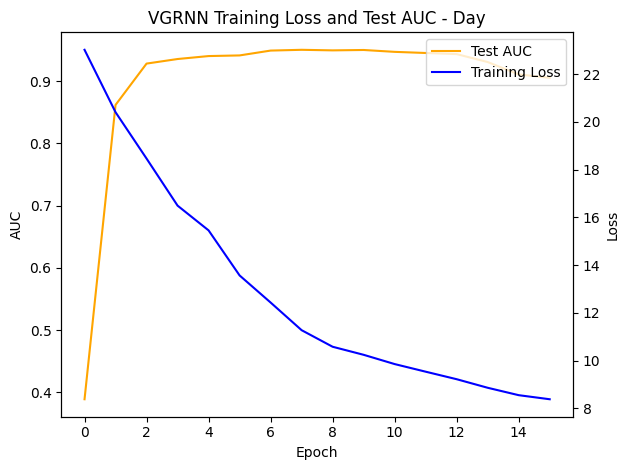

In [39]:
# Plotting the curves
fig, ax1 = plt.subplots()

# Plot test AUC curve on the left y-axis
ax1.plot(auc_values[:17], label='Test AUC', color='orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('AUC')
ax1.tick_params(axis='y')
ax1.set_title('VGRNN Training Loss and Test AUC - Day')
#ax1.set_ylim(0, 1)

# Ensure x-axis ticks are integers
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# Create a twin Axes sharing the xaxis with test AUC curve
ax2 = ax1.twinx()

# Plot training loss curve on the right y-axis
ax2.plot(loss_values[:16], label='Training Loss', color='blue')
ax2.set_ylabel('Loss')
ax2.tick_params(axis='y')

# Display legends for both curves
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.show()